# German Credit

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/main/learning_particle_gradients/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice
    
key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split

from functools import partial
import kernels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Data

In [2]:
data_path = "/home/lauro/code/msc-thesis/data/german.data-numeric"
data = onp.genfromtxt(data_path)
x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)

x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)

x /= (x_max - x_min)
x = 2.0 * x - 1.0
x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

num_features = x.shape[-1]

# Model

We can define the model using `tfd.JointDistributionCoroutine`.

In [137]:
a0, b0 = 0.5, 0.5
Root = tfd.JointDistributionCoroutine.Root

def get_model(features):
    def model():
        """generator"""
        dim_scales = yield Root(tfd.Sample(tfd.ExpGamma(a0, b0), 
                                              sample_shape=(num_features,), name="dim_scales"))
        overall_scale = yield Root(tfd.ExpGamma(a0, b0, name="overall_scale"))
        w = yield tfd.Normal(0., np.exp(dim_scales * overall_scale), name="w") # shape (num_features,)
        log_odds = jnp.dot(features, w)
        _ = yield tfd.Independent(tfd.Bernoulli(logits=log_odds), name="labels")                            # shape (len(features_batch),) in {0, 1}
    return model


def get_logp(x_batch, y_batch):
    def logp(params):
        dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_batch), validate_args=True)
        return dist.log_prob(tuple(params) + (y_batch,))
    return logp

train_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_train))
test_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_test))

def train_logp(params):
    return train_dist.log_prob(tuple(params) + (y_train,))

def test_logp(params):
    return test_dist.log_prob(tuple(params) + (y_test,))

key, subkey = random.split(key)
samples = train_dist.sample(seed=subkey)
tsamples = test_dist.sample(seed=subkey)

We can ravel (flatten) and unravel parameters like so:

In [140]:
params = train_dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [141]:
def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)


def train_logp_flat(flat_particles):
    return train_logp(unravel(flat_particles))

@jit
def train_logp_batch(flat_particles):
    return np.mean(vmap(train_logp)(batch_unravel(flat_particles)))

@jit
def test_logp_batch(flat_particles):
    return np.mean(vmap(test_logp)(batch_unravel(flat_particles)))

In [142]:
def get_schedule(eta):
    def polynomial_schedule(step):
        return eta / (step + 1)**0.55
    return constant_schedule

def get_probs(params):
    """
    Argument: sampled model parameters (single sample! need to vmap over sample batch)
    Returns logits shaped (n,)"""
    dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
    probs = dists[-1].distribution.probs_parameter() # spits out probability of labels
    return probs

def get_preds(params):
    """
    Argument: sampled model parameters (batch)
    Returns predictions on test set
    """
    probs = vmap(get_probs)(params) # shape (n_samples, n_data)
    return (probs.mean(axis=0) > 0.5).astype(np.int32)

@jit
def test_accuracy(params):
    """
    Argument: sampled model parameters (batch)
    Returns accuracy on test set
    """
    return np.mean(get_preds(params) == y_test)

In [176]:
NUM_VALS = 20 # number of test accuracy evaluations per run
NUM_STEPS = 500
PARTICLE_LR = 1e-3

In [177]:
def run_sgld(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)

    def energy_gradient(_, particles, aux=True):
        """params = [batch_x, batch_y]"""
        log_probs, grads = vmap(value_and_grad(train_logp_flat))(particles)
        if aux:
            return -grads, {"logp": np.mean(log_probs)}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_batch_flat, noise_level=1.,
                                learning_rate=PARTICLE_LR)

    for i in tqdm(range(NUM_STEPS+1)):
        particles.step(None)
        stepdata = {
            "accuracy": None,
            "test_logp": None
        }
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp_batch(particles.particles.training),
            }
        particles.write_to_log(stepdata)
    particles.perturb()
#     particles.done()
    return batch_unravel(particles.particles.training), particles

In [157]:
def run_svgd(init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)

    svgd_grad = models.KernelGradient(target_logp=train_logp_flat)
    particles = models.Particles(key, svgd_grad.gradient, init_batch_flat, 1e-1, "adam")

    for i in tqdm(range(NUM_STEPS+1)):
        particles.step(None)
        stepdata = {
            "accuracy": None,
            "test_logp": None
        }
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp_batch(particles.particles.training),
            }
        particles.write_to_log(stepdata)
#     particles.done()
    return batch_unravel(particles.particles.training), particles

In [158]:
def run_neural_svgd(key, init_batch):
    init_batch_flat = batch_ravel(init_batch)
    accs = []

    key1, key2 = random.split(key)
    neural_grad = models.SDLearner(target_dim=init_batch_flat.shape[1],
                                   target_logp=train_logp_flat,
                                   key=key1)
    particles = models.Particles(key2, neural_grad.gradient, init_batch_flat, optimizer="sgd")

    next_batch = partial(particles.next_batch, batch_size=150)
    for i in tqdm(range(NUM_STEPS+1)):
        neural_grad.train(next_batch=next_batch, n_steps=10)
        particles.step(neural_grad.get_params())
        stepdata = {
            "accuracy": None,
            "test_logp": None
        }
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp_batch(particles.particles.training),
            }
        particles.write_to_log(stepdata)
    neural_grad.done()
#     particles.done()
    return batch_unravel(particles.particles.training), particles, neural_grad

In [ ]:
# Run samplers
init_batch = train_dist.sample(200, seed=key)[:-1]
sgld_samples, sgld_p = run_sgld(key, init_batch)
svgd_samples,  svgd_p = run_svgd(init_batch)
neural_samples, neural_p, neural_grad = run_neural_svgd(key, init_batch)

 33%|███▎      | 164/501 [00:03<00:05, 63.49it/s]

In [ ]:
sgld_samples

In [160]:
sgld_aux = sgld_p.rundata
svgd_aux = svgd_p.rundata
neural_aux = neural_p.rundata

# neural rundata

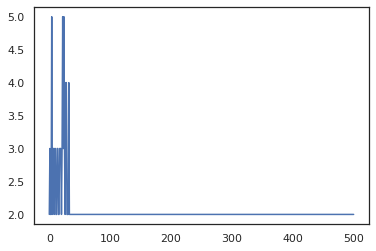

In [161]:
plt.plot(neural_grad.rundata["train_steps"])

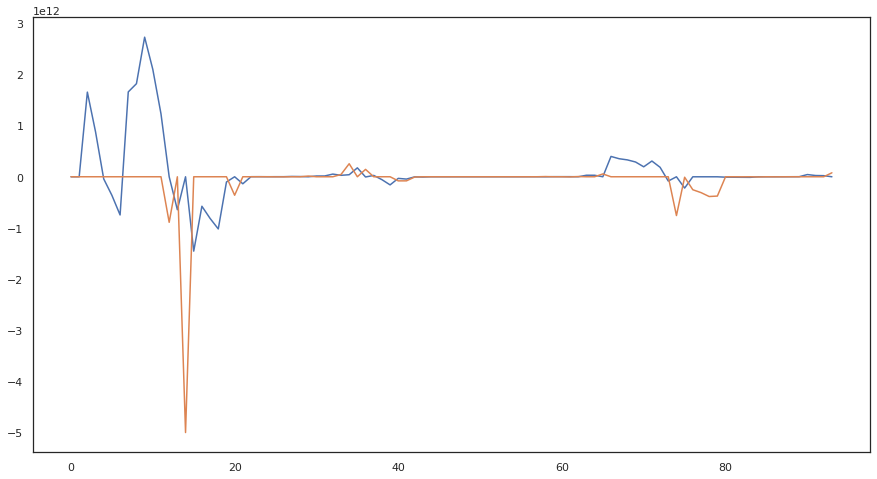

In [162]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_grad.rundata["training_loss"])
plt.plot(neural_grad.rundata["validation_loss"])

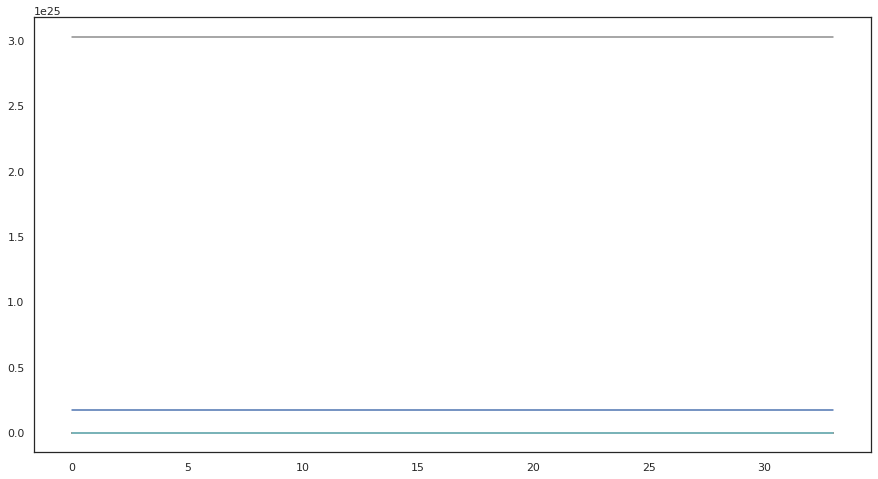

In [163]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_aux["training_mean"]);

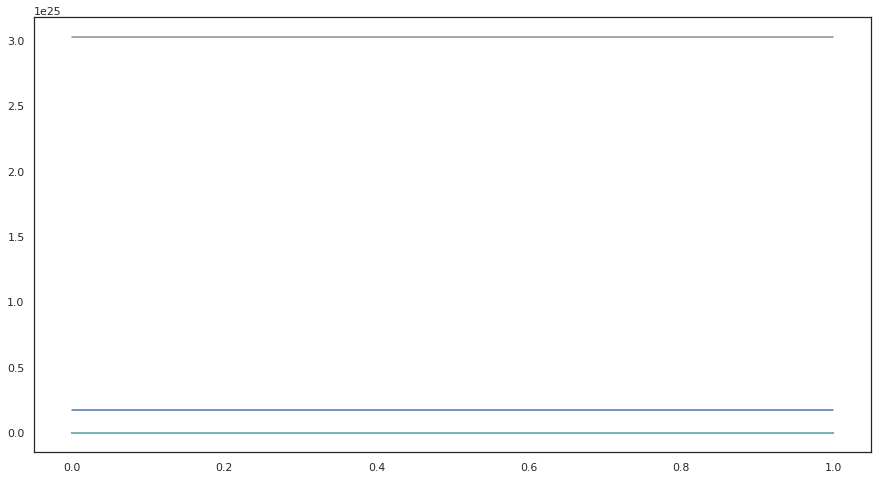

In [164]:
plt.subplots(figsize=[15, 8])
plt.plot(sgld_aux["training_mean"]);

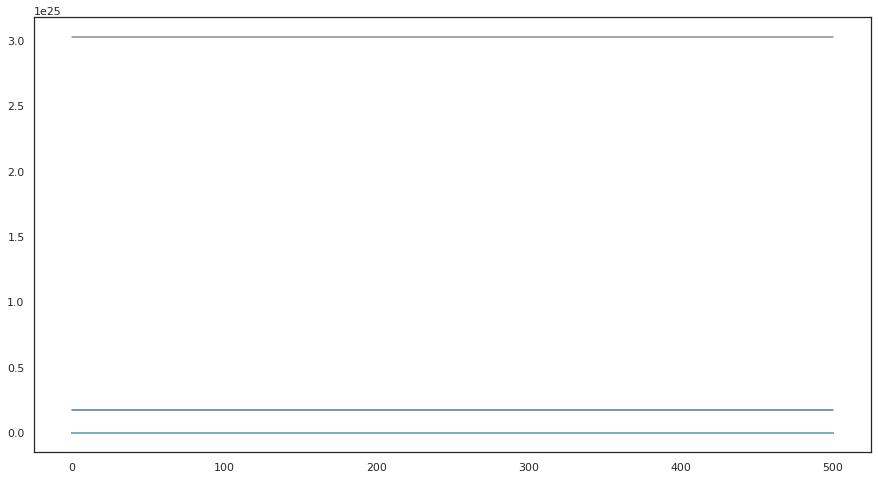

In [165]:
plt.subplots(figsize=[15, 8])
plt.plot(svgd_aux["training_mean"]);

## Evaluate samples on test set

In [166]:
sgld_accs, svgd_accs, neural_accs = [aux["accuracy"] for aux in (sgld_aux, svgd_aux, neural_aux)]

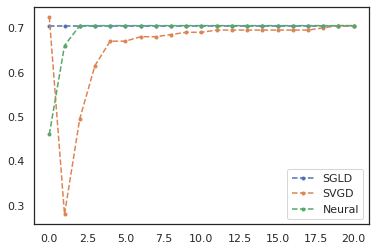

In [167]:
names = ["SGLD", "SVGD", "Neural"]
accs = [sgld_accs, svgd_accs, neural_accs]
for name, acc in zip(names, accs):
    acc = onp.array(acc)
    plt.plot(acc[np.isfinite(acc.astype(np.double))], "--.", label=name)
plt.legend()

In [169]:
print("SGLD accuracy:", test_accuracy(sgld_samples))
print("SVGD accuracy:", test_accuracy(svgd_samples))
print("Neural accuracy:", test_accuracy(neural_samples))
key, subkey = random.split(key)
print("prior samples accuracy:", test_accuracy(train_dist.sample(500, seed=subkey)[:-1]))

SGLD accuracy: 0.705
SVGD accuracy: 0.705
Neural accuracy: 0.705
prior samples accuracy: 0.505


### compute log-likelihoods (train and test)

In [173]:
test_logps = [test_logp_batch(batch_ravel(samples)) for samples in (sgld_samples, svgd_samples, neural_samples)]

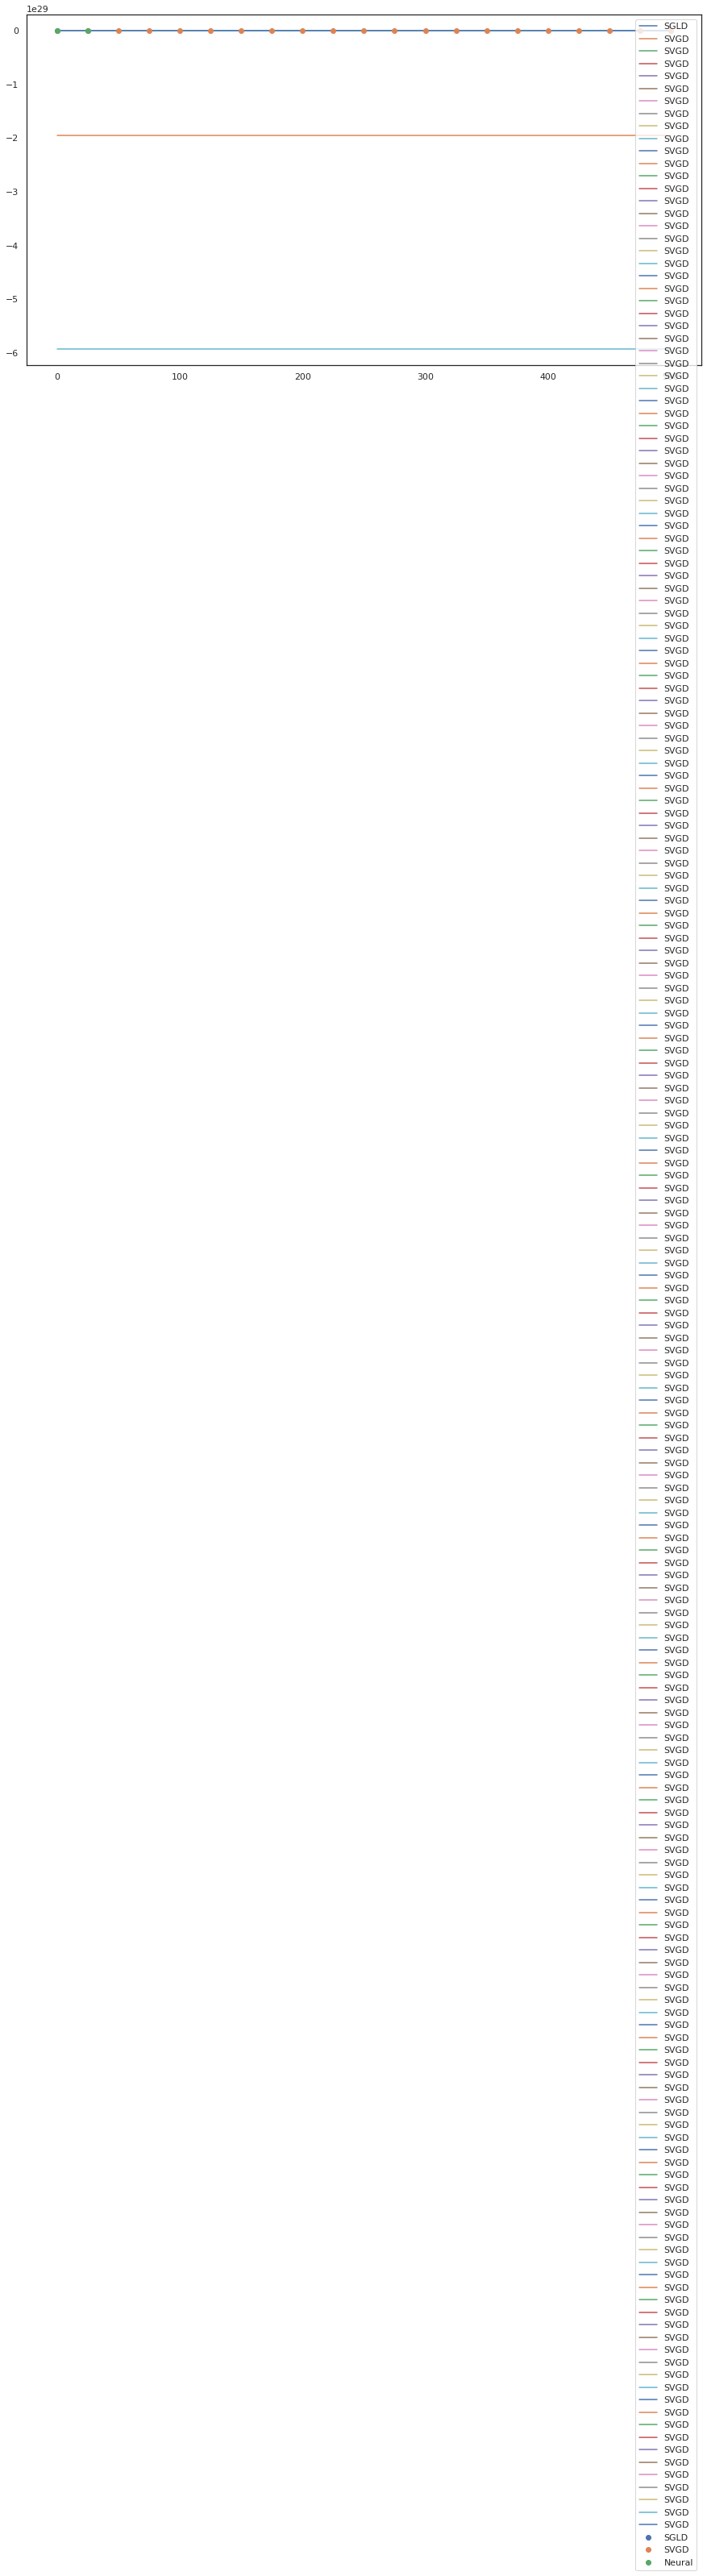

In [175]:
plt.subplots(figsize=[15, 8])

plt.plot(sgld_aux["training_logp"], label="SGLD")
plt.plot(svgd_aux["training_logp"], label="SVGD")
# plt.plot(neural_aux["training_logp"], label="Neural")


lines = plt.gca().get_lines()
colors = [line.get_color() for line in lines]
names = ["SGLD", "SVGD", "Neural"]
logps = [aux["test_logp"] for aux in (sgld_aux, svgd_aux, neural_aux)]
for name, lp, color in zip(names, logps, colors):
    plt.plot(lp, "o", label=name, color=color)

plt.legend()

In [ ]:
names = ["SGLD", "SVGD", "Neural"]
logps = [aux["test_logp"] for aux in (sgld_aux, svgd_aux, neural_aux)]
for name, lp in zip(names, logps):
    lp = onp.array(lp)
    plt.plot(lp[np.isfinite(lp.astype(np.double))], "--.", label=name)
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 5])

for i, meanlp in enumerate(test_logps):
    ax.bar(i, meanlp, label=names[i])

# ax.bar(i+1, mean_logp(x, y, batch_ravel(init_batch)), label="Init")
plt.legend()